In [0]:
import sys
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gym
# import gym_ple

from collections import deque

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD

In [0]:
# *******************************************************************************************
# Random seeds for reproducibility

# _seeds = np.random.randint(low = 0, high = 100, size = (3, 4))
# print(_seeds)

# Produced seeds:
# [[87 32 19 47]
#  [69 92  6 65]
#  [36 84 36 44]]

In [0]:
# *******************************************************************************************
# Environment Initialization

env = gym.make('CartPole-v0')

random.seed(87)
np.random.seed(32)
tf.set_random_seed(19)
env.seed(47)

state_size  = env.observation_space.shape[0]
action_size = env.action_space.n

print("Obseravtion spapce size: {}".format(state_size))
print("Action space size: {}".format(action_size))

C:\Users\Saeed\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Obseravtion spapce size: 4
Action space size: 2


In [0]:
# *******************************************************************************************
# Algorithm Parameters

n_episodes     = 5000
batch_size     = 32
total_steps    = 1e6
print_interval = 1

In [0]:
# *******************************************************************************************
# CLASS

class Agent:  
    def __init__(self, state_size, action_size):
        
# ********************************
# Parameters 

        self.state_size    = state_size
        self.action_size   = action_size
        self.counter       = 0
        self.eval_interval = 200
        self.epsilon       = 1.0
        self.epsilon_min   = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.alpha         = 0.002     

        self.loss1         = list()
        self.loss2         = list()
        self.loss_reverse1 = list()
        self.loss_reverse2 = list()
        
        
        self.reverse_horizon  = 4
        self.aug_traj_count   = 4
        self.initial_steps    = 0
        self.total_back_steps = 2
        
#  Optimized hyper parameters        
#         self.reverse_horizon  = 4
#         self.aug_traj_count   = 1
#         self.initial_steps    = 10
#         self.total_back_steps = 2
#         self.alpha         = 0.01     


        
        
# ********************************
# Memories

        self.memory_tape = deque(maxlen=20000)
        self.memory_full = deque(maxlen=None)
        self.state_memory = deque(maxlen=20000)
        self.memory_episode = deque(maxlen=200)    
        self.horizon = deque (maxlen = self.reverse_horizon)
#         self.augmented_reverse_horizon = deque (maxlen = self.reverse_horizon)

        self.reward_string = self.build_reward_string()
#         plt.plot(self.reward_string) # This is to plot the credit assignment string
#         plt.show()

# ********************************
# Models

        self.model         = self.build_model()
        self.model_eval    = self.build_network_eval()
        self.model_reverse = self.build_model()

# *******************************************************************************************
# FUNCTIONS

# ********************************
# Neural Networks

    def build_network(self):
        nn = Sequential()
        nn.add(Dense(16, input_dim = state_size , activation='relu'))
        nn.add(Dense(16, activation='relu'))
        nn.add(Dense( state_size , activation='linear'))
        nn.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return nn
    
    def build_model(self):
        model = list()
        for i in range(action_size):
            model.append(self.build_network())
        return model
    
    def build_network_eval(self):
        nn = Sequential()
        nn.add(Dense(16, input_dim = state_size , activation='relu'))
        nn.add(Dense(16, activation='relu'))
        nn.add(Dense( 1 , activation='linear'))
        nn.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return nn

# ********************************
# Replay Buffer

    def remember_tape(self, state, action, next_state):
        self.memory_tape.append((state, action, next_state)) 
        self.horizon.append((state, action))
              
    def remember_episode(self, state, action, next_state):
        self.memory_episode.append((state, action, next_state)) 
        
# ********************************
# Policy

    def act(self, state):
#         TODO: This is manual now,
#         instead of two separate networks, a network and output of action_size should be used
        if np.random.rand() <= self.epsilon:
            act = np.random.randint(self.action_size)
            return act
        
        self.future = list()
        evaluated   = list()
        state       = np.reshape(state, [1,state_size])
            
        predicted_state0 = self.model[0].predict(state)
        predicted_state1 = self.model[1].predict(state)
        eval_state0 = self.evaluate_state(predicted_state0)        
        eval_state1 = self.evaluate_state(predicted_state1)
        evaluated = [eval_state0 , eval_state1]
        
        if eval_state0 == eval_state1:               
            act = np.random.randint(2)
            return act
        
        act = np.argmin(evaluated)
        return act
  
    def evaluate_state(self,state):
        eval = self.model_eval.predict(state)
        return eval
    
# ********************************
# Models   
    def train(self):
        
        minibatch = random.sample(self.memory_tape, min(len(agent.memory_tape),batch_size))
        
        for state, action, next_state in minibatch:
            state = np.reshape(state, [1,state_size])
            next_state = np.reshape(next_state, [1, state_size]) 
            
            self.model[action].fit(state, next_state, epochs=1, verbose=0)
            self.model_reverse[action].fit(next_state, state, epochs=1, verbose=0)
            
        if (self.counter % self.eval_interval == 0):
            eval_score = self.model[action].evaluate(state, next_state, verbose=1,steps=1)
            eval_score_reverse = self.model_reverse[action].evaluate(state, next_state, verbose=1,steps=1)
            
            if action ==0:
                self.loss1.append(eval_score)
                self.loss_reverse1.append(eval_score_reverse)

            else:
                self.loss2.append(eval_score)
                self.loss_reverse2.append(eval_score_reverse)

        self.counter += 1
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def eval_train(self):
#         TODO: Datasets should be combined before learning(fitting)
#         if (self.counter > self.initial_steps):
        
#             self.augment_samples()
    
  
            
       
        boundary = np.reshape (agent.horizon,[4, 2])
        
        boundary = np.concatenate((boundary, self.reward_string), axis = 1)
        
        for state, i, reward in boundary:
            
            state  = np.reshape(state, [1,state_size])
            
            reward = self.model_eval.predict(state) * (1-self.alpha) + reward * self.alpha
            
            self.model_eval.fit(state, reward, epochs=1, verbose=0)
        
        temp   = self.memory_episode
    
        lenght = len(temp)
        
        temp   = np.reshape(temp, [lenght,3])
        
        temp   = tuple(temp[:-4])
        
        temp   = random.sample(temp, 4)
        
        for state, action, next_state in temp:
            
            state  = np.reshape(state, [1,state_size])
            
            reward = self.model_eval.predict(state) * (1-self.alpha)
            
            self.model_eval.fit(state, reward, epochs=1, verbose=0) 
            
    def build_reward_string(self):
#         TODO: This is manual now, It is a parameter that should be evaluated
        return np.reshape(np.array([0.25, 0.5, 0.75, 1]),[4,1])

    def augment_samples(self):
        
        credit = self.build_reward_string()
        
        last_state = self.horizon[-1][0] 
               
        for _trajectory in range(self.aug_traj_count):
            
            current_state = last_state
            
            for backward_step in range(self.total_back_steps):
                
                random_reverse_action = np.random.randint(self.action_size)
                
                current_state  = np.reshape(current_state, [1,state_size])
                
                past_state = self.model_reverse[random_reverse_action].predict(current_state)
                
                reward = self.model_eval.predict(past_state) * (1-self.alpha) + credit[-backward_step-2] * self.alpha
                
                self.model_eval.fit(past_state, reward, epochs=1, verbose=0)
                
                current_state = past_state
                

In [0]:
# *******************************************************************************************
# Main 

agent  = Agent(state_size, action_size)

_steps = 0
done   = False
score  = list()

cons_success    = 0
done_in         = n_episodes
render_interval = 25
state_full      = list()

for e in range(n_episodes):
    
    state_episode = np.zeros((1,4))
    state = env.reset()
    agent.state_memory.clear()
    
    for time in range(200):
        
#       if e % render_interval ==0: 
#         env.render(mode="human") 

        action = agent.act(state)
        state_episode = np.concatenate ((state_episode , (np.reshape(state,(1,4)))),axis=0)
        next_state, reward, done, _ = env.step(action)
        _steps += 1
        
        if _steps >= total_steps:
            print("total steps of {} reached".format(total_steps))
            sys.exit()
            
        agent.remember_tape(state, action, next_state)
        agent.remember_episode(state, action, next_state)



        agent.state_memory.append(state)   
        state = next_state
        
        if done:
            if (e % print_interval) == 0:
                print("episode: {}/{}, score: {}, e: {:.2}, total steps: {}".format(e, n_episodes, time, agent.epsilon,_steps))
            
            state_full.append(state_episode)
            
            score.append(time)
            np.savetxt('bk_linear_H4_1.out', score, delimiter=',')
            np.savetxt('bk_linear_H4_1.out', score, fmt='%d')
            
            # to record 100 consecutive success
            if ((len(agent.state_memory)) >= 195):
                consecutive_success += 1
            else:
                consecutive_success = 0
            if consecutive_success == 100:
                done_in = e
                print ("Done in:", done_in-100, "Epidodes -------------------------------------------------------" )
                
            
            
            if ((len(agent.state_memory)) < 198) and ((len(agent.state_memory)) > 2*agent.reverse_horizon):
                agent.eval_train()

#             if len(agent.memory_tape) > batch_size:
            agent.train()
            
            break
            
    agent.state_memory.clear()
    agent.memory_episode.clear()

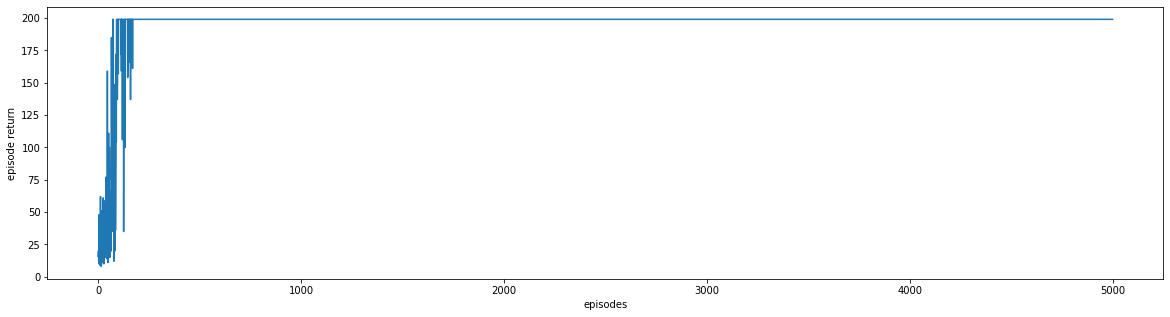

In [0]:
# *******************************************************************************************
# plot the learning curve

fig, ax = plt.subplots()
ax.plot(score)
fig.set_size_inches(20,5)
ax.set_xlabel('episodes')
ax.set_ylabel('episode return')
plt.show()

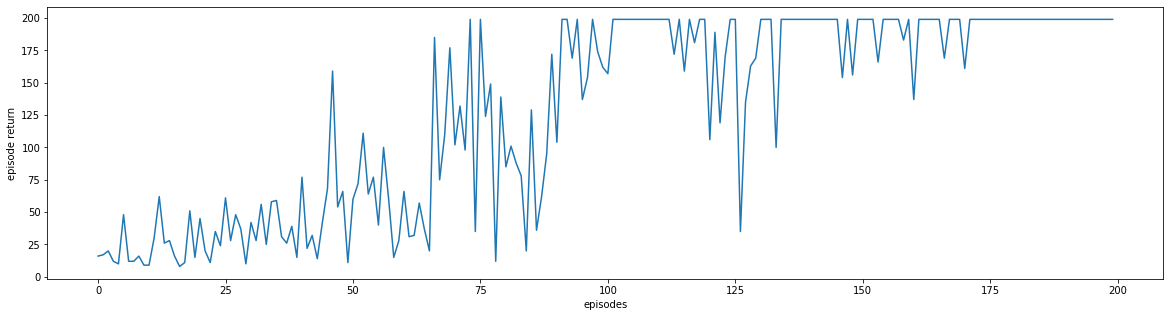

In [0]:
# *******************************************************************************************
# plot the learning curve

fig, ax = plt.subplots()
ax.plot(score[:200])
fig.set_size_inches(20,5)
ax.set_xlabel('episodes')
ax.set_ylabel('episode return')
plt.show()

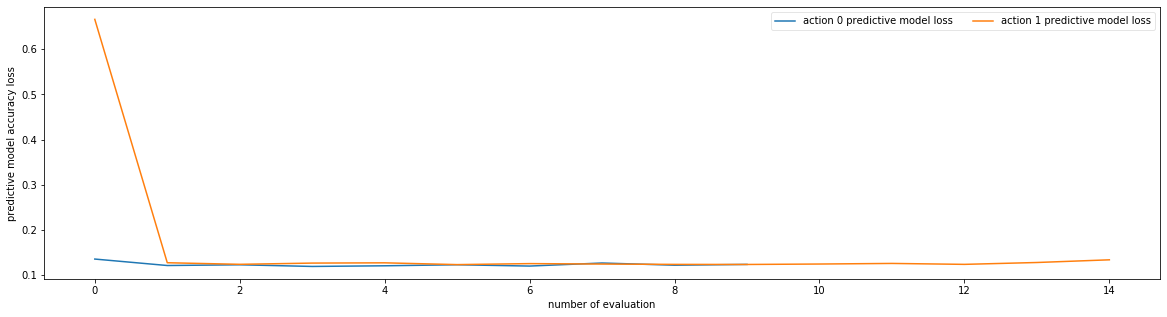

In [0]:
# *******************************************************************************************
# plot the model accuracy

fig, ax = plt.subplots()
plt.plot(agent.loss_reverse1, label="action 0 predictive model loss")
plt.plot(agent.loss_reverse2, label="action 1 predictive model loss")
fig.set_size_inches(20,5)
ax.set_xlabel('number of evaluation')
ax.set_ylabel('predictive model accuracy loss')
leg = plt.legend(loc='best', ncol=2)
leg.get_frame().set_alpha(0.5)
plt.show()

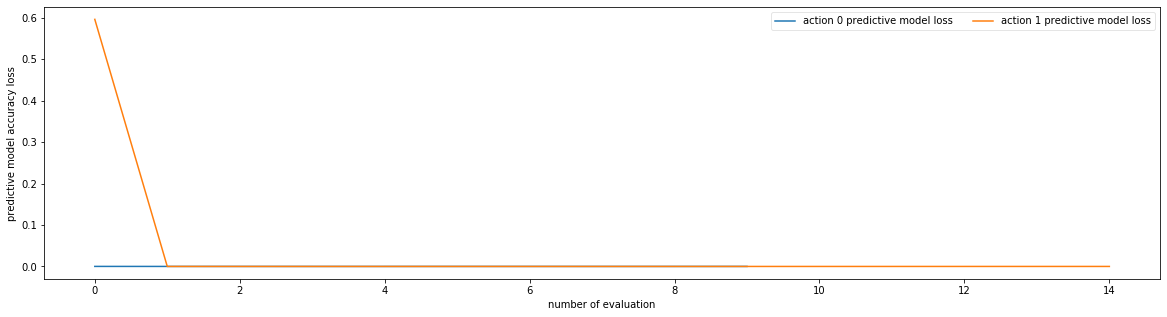

In [0]:
# *******************************************************************************************
# plot the model accuracy

fig, ax = plt.subplots()
plt.plot(agent.loss1, label="action 0 predictive model loss")
plt.plot(agent.loss2, label="action 1 predictive model loss")
fig.set_size_inches(20,5)
ax.set_xlabel('number of evaluation')
ax.set_ylabel('predictive model accuracy loss')
leg = plt.legend(loc='best', ncol=2)
leg.get_frame().set_alpha(0.5)
plt.show()

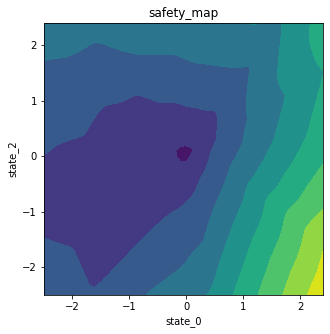

In [0]:
x = np.arange(-2.5, 2.5, 0.1)
y = np.arange(-2.500, 2.500, 0.100)
xx, yy = np.meshgrid(x, y, sparse=True)

z = np.zeros((np.shape(x)[0],np.shape(y)[0]))
for i in range(np.shape(x)[0]):
    for j in range(np.shape(y)[0]):
        c = [[x[i],0,y[j],0]]
        z[i,j] = agent.model_eval.predict(np.array(c))

fig, ax = plt.subplots()
plt.contourf(x,y,z)
fig.set_size_inches(5,5)
ax.set_xlabel('state_0')
ax.set_ylabel('state_2')
ax.set_title('safety_map')
plt.show()